## Часть 6. Линейная Алгебра и Машинное Обучение  

Хорошее знание линейной алгебры очень важно в современном машинном обучении. В этом задании Вам предлагается реализовать метод машинного обучения применив знания матричного дифференцирования и итерационных методов решения систем уравнений :) 

В области машинного обучения одним из самых популярных методов бинарной классификации (предсказываем один из двух классов, $+1$ или $-1$ для каждого объекта) является логистическая регрессия. Она выводится из метода максимального правдоподобия, который приводит к следующей задаче оптимизации:

$$ L(w, X, y) = \sum_{i = 0}^{N} log (1 + exp(-y_ix_i^Tw)) + \frac{C}{2} ||w||^2 \longrightarrow \min_w$$
$$X \in R^{N \times M}, x \in R^{M}, w \in R^{M}, y \in \{-1, 1\}^N$$

Здесь $X$ - матрица объекты-признаки для обучающей выборки (по строкам объекты, по столбцам признаки), а $y$ - вектор ответов. Коэффициент $C$, вообще говоря, нужно подбирать отдельно, поскольку разные его значения приводят к разным решениям задачи оптимизации. Но так как это уже никакого отношения не имеет к линейной алгебре, то в этой задаче мы положим $\mathbf{C = 1}$

Когда мы решили задачу оптимизации (нашли $w$), мы принимаем решение о том, к какому классу относится объект по правилу $y(x) = sign(x^Tw)$. В данной части вам необходимо применить методы линейной алгебры для решения этой задачи. 

План у нас такой:
- Вычислить градиент функции $L$, эффективно запрограммировать и проверить себя
- Вычислить гессиан функции $L$,  эффективно запрограммировать и проверить себя
- Воспользоваться методом второго порядка для оптимизации 
- Внутри метода оптимизации вместо обращения матрицы, решать систему уравнений с помощью итерационного метода
- Исследовать эффективность различных методов решения системы уравнений на реальных данных

In [71]:
import numpy as np
import scipy.linalg as sla
import scipy.sparse as sps
import scipy.sparse.linalg as spla
from scipy import special
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 20, 20
%matplotlib inline

Для тестирования правильности вычисления сгенерируем аргументы небольшого размера

In [2]:
w, X, y = np.random.random(10), np.random.random((11, 10)), 2*(np.random.randint(0, 2, 11)-0.5)

**Задача 6.0 (0,5 балла)**

Запрограммируйте вычисление функции L, используйте только матричные операции (внутри не должно быть циклов).

**Замечание**: Нигде в промежуточных вычислениях не стоит вычислять значение $exp(−y_ix^Tw)$, иначе может произойти переполнение. Вместо этого следует напрямую вычислять необходимые величины с помощью специализированных для этого функций: `np.logaddexp` для `ln(1 + exp(·))` и `sp.special.expit` для `1/(1 + exp(-(·)))`.

In [4]:
def oneaddexp(x):
        return np.logaddexp(0, x)
vector_logaddexp = np.vectorize(oneaddexp)

def logistic(w, X, y):
    '''
        logistic(w, X, y) вычисляет функцию качества лог регрессии L(w, X, y)
        
        w: np.array размера (M,)
        X: np.array размера (N, M)
        y: np.array размера (M,)
        
        funcw: np.float 
    '''
    dot = np.squeeze(np.asarray(X.dot(w.T)))
    funcw = vector_logaddexp(-y * dot)
    return funcw.sum() + 0.5 * sla.norm(w) ** 2

In [5]:
logistic(w, X, y)

21.310141356234976

$$ L(w, X, y) = \sum_{i = 0}^{N} log (1 + exp(-y_ix_i^Tw)) + \frac{C}{2} ||w||^2 \longrightarrow \min_w$$

$$X \in R^{N \times M}, x \in R^{M}, w \in R^{M}, y \in \{-1, 1\}^N$$

**Задача 6.1 (1 балл)**

Найдите градиент функции $\nabla_w L(w, X, y)$, запишите в терминах матричных операций

Продифференцируем $L(w, X, y)$ по $w_j$. Производная $||w||^2$ очевидно равна $2w_j$. 

$$\log{(1 + exp(-y_i \cdot x_i^{T} \cdot w)})_{w_j}^{'} = \frac{1}{1 + exp(-y_i \cdot x_i^{T} \cdot w)} \cdot exp(-y_i \cdot x_i^{T} \cdot w) \cdot -y_i \cdot x_{ij} = \frac{-y_i \cdot x_{ij}}{1 + exp(y_i \cdot x_i^{T} \cdot w)}$$

Следовательно: $$\frac{\partial L(w, X, y)}{\partial w_j} = \sum_{i=1}^{N} \frac{-y_i \cdot x_{ij}}{1 + exp(y_i \cdot x_i^{T} \cdot w)} + w_j$$

$$ \frac{\partial L(w, X, y)}{\partial w} = X \left( \frac{-y_1}{1 + exp(y_1 \cdot x_1^{T} \cdot w)}, \cdots,
\frac{-y_N}{1 + exp(y_N \cdot x_N^{T} \cdot w)} \right)^{T} + w$$

Эффективно запрограммируйте вычисление градиента (опять же, только матричные операции!)

Обратите внимание на то, что для разреженных матриц понадобится написать немного другой код.

In [11]:
import scipy

def expbyexp(x):
    return scipy.special.expit(x)
vector_expbyexp = np.vectorize(expbyexp)

def logistic_grad(w, X, y):
    '''
        logistic_grad(w, X, y) вычисляет градиент функции качества лог регрессии dL(w, X, y)/dw
        
        w: np.array размера (M,)
        X: np.array размера (N, M)
        y: np.array размера (M,)
        
        gradw: np.array размера (M,)
    '''
    if sps.issparse(X):
        dot = np.squeeze(np.asarray(X.dot(w.T)))
        funcw = vector_expbyexp(-y * dot)
        gradw = np.squeeze(np.asarray(X.T.dot((-y * funcw).T))) + w
    else:
        dot = np.squeeze(np.asarray(np.dot(X, w.T)))
        funcw = vector_expbyexp(-y * dot)
        gradw = np.squeeze(np.asarray(np.dot(X.T, (-y * funcw).T))) + w
    return gradw

In [12]:
assert(logistic_grad(w, X, y).shape == w.shape)

In [13]:
w = np.array([2, 3])
X = sps.csr_matrix([[4, 1], [3, 1], [4, 2]])
y = np.array([0.5, 21, 3])
logistic_grad(w, X, y)

array([ 1.99185972,  2.99796493])

Очень часто при подсчёте градиента допускаются ошибки, проверьте правильность реализации подсчёта градиента с помощью конечных разностей. 

$$[\nabla f(x)]_i \approx \frac{f(x + \epsilon \cdot e_i) - f(x)}{\epsilon}~~~~$$

где $e_i = (0, ... , 0, 1, 0, ..., 0)$ - i-й базисный орт, $\epsilon \approx 10^{-8}$

Ваша функция должна корректно работать хотя бы с обыкновенными (не разреженными матрицами)

In [17]:
def max_error(a, b): 
    return np.max(np.abs(a-b))

def grad_finite_diff(func, w, eps=1e-8):
    '''
        w: np.array размера (M,)
        func: скалярная функция от векторного аргумента w, func(w) =  число
        eps: np.float константа для проверки градиента
        
        dnum: np.array размера (M,), численно посчитанный градиент
    '''
    w, fval, dnum = w.astype(np.float64), func(w), np.zeros_like(w)

    for i in range(w.size):
        ei = np.zeros(len(w))
        ei[i] = 1
        dnum[i] = (func(w + eps * ei) - func(w)) / eps
        # dnum[i] = # Вычислите численный градиент d func/dw_i с помощью конечных разностей

    return dnum

In [19]:
w, X, y = np.random.random(10).astype(np.float128), np.random.random((11, 10)).astype(np.float128), 2*(np.random.randint(0, 2, 11)-0.5).astype(np.float128)

mat_grad = logistic_grad(w, X, y)
num_grad = grad_finite_diff(lambda w: logistic(w, X, y), w)

err = max_error(mat_grad, num_grad)
print('err = ', err, 'ok' if err < 1e-6 else 'ошибка очень большая =(')

err =  2.49193360716e-08 ok


**Задача 6.2 (1 балл)**

Для некоторых задач оптимизации очень удобно использовать гессиан. 

Вычислите гессиан для функции L, запишите ответ в терминах матричных операций. 

**Упражнение**: Можно ли что-то сказать про знакоопределенность этой матрицы?

Из прошлой задачи мы знаем, что 
$$\frac{\partial L(w, X, y)}{\partial w_j} = 
\sum_{i=1}^{N}{\frac{-y_i \cdot x_{ij}}{1 + \exp(y_i \cdot x_i^{T} \cdot w)}} + w_j$$.

Найдем гессиан $L$, продифференцировав каждый член этой суммы по отдельности по $\partial w_k$. 

$$\left( \frac{1}{1 + e^{y_i \cdot x_i^{T} \cdot w}} \right)_{w_k}^{'} = 
\frac{-y_i \cdot x_{ik} \cdot e^{y_i \cdot x_{i}^{T}\cdot w}}
{\left( 1 +  e^{y_i \cdot x_{i}^{T}\cdot w} \right) ^ {2}}
$$

Отсюда получаем: 
$$\frac{\partial L(w, X, y)}{\partial w_j \partial w_k} = 
\sum_{i = 1}^{N}
{\frac{y_i^{2} \cdot x_{ik} \cdot x_{ij} \cdot e^{y_i \cdot x_{i}^{T}\cdot w}}
{\left( 1 +  e^{y_i \cdot x_{i}^{T}\cdot w} \right) ^ {2}}}
+ \delta_{jk} =  
\sum_{i = 1}^{N}
{\frac{1 \cdot x_{ik} \cdot x_{ij} \cdot e^{y_i \cdot x_{i}^{T}\cdot w}}
{\left( 1 +  e^{y_i \cdot x_{i}^{T}\cdot w} \right) ^ {2}}}
+ \delta_{jk}$$

Эффективно запрограммируйте вычисление гессиана. Не забудьте написать отдельную рутину для разреженных матриц.

In [22]:
def diff_exp(x):
        return scipy.special.expit(x) * scipy.special.expit(-x)
vector_diff_exp = np.vectorize(diff_exp)

def logistic_hess(w, X, y):
    '''
        logistic_hess(w, X, y) вычисляет гессиан функции качества лог регрессии dL(w, X, y)/dw
        
        w: np.array размера (M,)
        X: np.array размера (N, M)
        y: np.array размера (M,)
        
        hessw: np.array размера (M, M)
    '''
    if sps.issparse(X):
        N = X.shape[0]
        M = X.shape[1]
        X_copy = X.T.tocsr()
        dotXW = X.dot(w.T)
        vector_exp = sps.csr_matrix(vector_diff_exp(y * dotXW))
        vector_exp = sps.csr_matrix(np.ones(M).reshape(M, 1)).dot(vector_exp)
        XTmult = X_copy.multiply(vector_exp)
        hessw = XTmult.dot(X) + np.identity(w.size)
    else:
        dotXW = np.squeeze(np.asarray(X.dot(w.T)))
        vector_exp = vector_diff_exp(y * dotXW)
        hessw = np.dot(np.asarray(X).T * vector_exp, X) + np.identity(w.size)
    return hessw

In [23]:
assert(logistic_hess(w, X, y).shape == (w.shape[0], w.shape[0]))

Теперь проверим правильность реализации подсчёта гессиана

Для гессиана проверка выглядит похожим образом

$$[\nabla^2 f(x)]_{ij} \approx \frac{f(x + \epsilon \cdot e_i + \epsilon \cdot e_j) -f(x + \epsilon \cdot e_i) - f(x + \epsilon \cdot e_j)+ f(x)}{\epsilon^2}~~~~~~~~~~~~~~~~~~~~~$$

где $e_i = (0, ... , 0, 1, 0, ..., 0)$ - i-й базисный орт, $\epsilon \approx 10^{-5}$

In [25]:
def hess_finite_diff(func, w, eps=1e-5):
    '''
        w: np.array размера (M,)
        func: скалярная функция от векторного аргумента w, func(w) =  число
        eps: np.float константа для проверки градиента
        
        dnum: np.array размера (M,), численно посчитанный градиент
    '''
    w, fval, dnum = w.astype(np.float64), func(w).astype(np.float64), np.zeros((w.size, w.size), dtype=np.float64)
    E = eps * np.identity(w.size).astype(np.float64)
    for i in range(w.size):
        for j in range(w.size):
            dnum[i][j] = (func(w + E[i] + E[j]) + func(w) - func(w + E[i]) - func(w + E[j])) / (eps * eps)
    return dnum

In [26]:
mat_grad = logistic_hess(w, X, y)
num_grad = hess_finite_diff(lambda w: logistic(w, X, y), w)

err = max_error(mat_grad, num_grad)

print('err = ', err)
print('ok' if max_error(mat_grad, num_grad) < 1e-5 else 'ошибка оч большая =(') 

err =  5.99059356447e-06
ok


**Задача 6.3 (3+ баллов)**

Так как наша задача оптимизации оказывается выпуклой (см. упражнение про знакоопределённость Гессиана), её можно эффективно решать методом второго порядка, например, методом Ньютона. Напомним, что в общем виде метод Ньютона для решения уравнения (системы уравнений) $H(z) = 0$ имеет вид

$$z_{k+1} = w_k - \mathbf{\alpha_k}\left(\nabla H(z_k)\right)^{-1}H(z_k)$$

Множитель $a_k$ не вполне каноничен, но его введение может ускорять сходимость.

Решение задачи оптимизации $f(w) \rightarrow \min\limits_w$ сводится к нахождению нулей градиента $\nabla f(w) = 0$. Получаем следующий итеративный процесс:

$$w_{k + 1} = w_k - \alpha_k\left(\nabla^2 f(x_k)\right)^{-1} \cdot \nabla f(x_k) =: w_k - \alpha_k d_k$$

Иными словами, основная идея метода Ньютона -- на шаге $k$ выбрать направление спуска $d_k$ с помощью градиента и гессиана, определить длину шага $\alpha_k$ по направлению $d_k$, и повторять сей процесс до сходимости (в выпуклой задаче можно считать, что это 20 итераций).

В методе Ньютона каждое следующее направление оптимизации выбирается как 

$$d_{k+1} = -(\nabla^2 f(x_k))^{-1} \cdot \nabla f(x_k)$$

но, вот беда, операция поиска обратной матрицы очень дорогая и не устойчивая, поэтому будем искать $d_{k+1}$ как решение системы уравнений

$$\nabla^2 f(x_k) d_{k+1} = -\nabla f(x_k)$$

Первым делом вам нужно будет реализовать метод Ньютона.

*Замечание*: Если вы хорошо реализовали вычисление градиента и гессиана, то в функции `newton` вам не понадобилось отдельно обрабатывать разреженные матрицы.

In [46]:
from scipy.optimize.linesearch import line_search_armijo
import time

def newton(func, grad, hess, w0, solver, max_iter=20):
    '''
        func: скалярная функция от вектора размера shape(w0)
        grad: функция вычисляющая градиент функции func
        hess: функция вычисляющая гессиан  функции func
        
        w0: вектор, первая точка в процессе оптимизации 
        solver: функция от двух аргументов A, b находит решение системы Ax=b
        max_iter: количество итераций метода
    '''
    
    w, fvals, ngrads = w0.copy().astype(np.float128), [], []

    time_grad_hess = 0.
    time_solver = 0.
    
    for _ in range(max_iter):
        start_time = time.time()
        fvalx, gradx, hessx = func(w), grad(w), hess(w)
        end_time = time.time()
        time_grad_hess += end_time - start_time
        start_time = end_time
        d = solver(hessx, -gradx)
        time_solver += time.time() - start_time
        alpha = line_search_armijo(func, w, d, gradx, fvalx)[0]
        w += alpha * d
        fvals.append(fvalx)
        ngrads.append(np.linalg.norm(gradx))

    print('time for computing hessian and gradient: {}'.format(time_grad_hess))
    print('time for solving linear system: {}'.format(time_solver))
        
    return w, fvals, ngrads

In [47]:
# Пример запуска

func = lambda w: logistic(w, X, y)
grad = lambda w: logistic_grad(w, X, y)
hess = lambda w: logistic_hess(w, X, y)
gauss_  = lambda A, b: spla.spsolve(A, b) if sps.issparse(A) else sla.solve(A, b)
lgmres_  = lambda A, b: spla.lgmres(A, b, tol=1e-2)[0]
cg_  = lambda A, b: spla.cg(A, b, tol=1e-2)[0]

%time w_opt, fvals, ngrads = newton(func, grad, hess, w, cg_) 

time for computing hessian and gradient: 0.012771129608154297
time for solving linear system: 0.005862236022949219
CPU times: user 24 ms, sys: 0 ns, total: 24 ms
Wall time: 24.8 ms


В этом задании вам необходимо в зависимости от метода решения системы уравнений (гаусс, CG, GMRES) исследовать:
- зависимость времени работы метода оптимизации от выбора метода решения системы;
- скорость сходимости метода оптимизации в зависимости от точности решения системы уравнений (параметр `tol`);
- какую часть времени метод тратит на решение системы уравнений и какую на вычисление гессиана и градиента.

Эксперименты нужно провести на нескольких наборах данных. Рассмотрите следующие три ситуации: 
- малое число признаков d < 100
- среднее число признаков d ~ 500 
- большое число признаков d ~ 1000

Мы будем поощрять любые дополнительные исследования, например, если вы попытаетесь проверить статистическую значимость результатов экспериментов: ведь если какой-нибудь метод показал себя лучше в одном-единственном эксперименте, то это ещё ничего не значит.

**Рекомендация**: можете рассмотреть три набора данных, которые можно скачать с сайта [LIBSVM1](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html): **a9a**, **w8a** (много объектов, сравнительно немного признаков) и **colon-cancer** (в нём достаточно мало объектов, но зато гораздо больше признаков).

Любой набор данных с сайта LIBSVM представляет из себя текстовый файл в формате svmlight. Чтобы считать такой текстовый файл, можно использовать функцию [load_svmlight_file](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_svmlight_file.html) из модуля sklearn.datasets. Эта функция всегда возвращает матрицу X типа sp.sparse.csr_matrix (разреженная марица). В датасете **colon-cancer** матрица X не будет разреженной, поэтому сразу же после вызова функции load_svmlight_file следует привести X к типу np.ndarray. Это можно сделать с помощью команды X = X.toarray().

Начнем с датасета colon-cancer, в котором большое число признаков.

## Colon - cancer

In [55]:
import sklearn
from sklearn import datasets
X_cancer = sklearn.datasets.load_svmlight_file('./colon-cancer')
Y_cancer = X_cancer[1].astype(np.float128)
X_cancer = X_cancer[0].toarray().astype(np.float128)

In [56]:
X_cancer

array([[ 2.08075,  1.09907,  0.927763, ..., -0.148522,  1.59153, -0.217481],
       [ 1.10946,  0.786453,  0.44556, ...,  1.09401, -0.492141, -1.55408],
       [-0.67653,  1.6931,  1.55925, ..., -0.086285, -0.390878, -0.089465],
       ..., 
       [ 0.200706, -0.668545, -0.935933, ...,  0.605018,  1.34491, -2.48507],
       [ 0.829749,  0.299447,  0.130738, ...,  0.98563, -0.210661,
        -0.391249],
       [ 0.566684, -0.53366, -0.761951, ..., -0.45384,  0.194535,  0.06415]], dtype=float128)

In [62]:
func = lambda w: logistic(w, X_cancer, Y_cancer)
grad = lambda w: logistic_grad(w, X_cancer, Y_cancer)
hess = lambda w: logistic_hess(w, X_cancer, Y_cancer)
gauss_  = lambda A, b: spla.spsolve(A, b) if sps.issparse(A) else sla.solve(A, b)
lgmres_  = lambda A, b: spla.lgmres(A, b)[0]
cg_  = lambda A, b: spla.cg(A, b)[0]

w = np.zeros(X_cancer.shape[1])
%time w_opt, fvals, ngrads = newton(func, grad, hess, w, lgmres_)
%time w_opt, fvals, ngrads = newton(func, grad, hess, w, cg_)
%time w_opt, fvals, ngrads = newton(func, grad, hess, w, gauss_)
print(w_opt)
print(sla.norm(grad(w_opt)))

time for computing hessian and gradient: 23.479949235916138
time for solving linear system: 2.00423264503479
CPU times: user 17.9 s, sys: 7.54 s, total: 25.5 s
Wall time: 25.5 s
time for computing hessian and gradient: 24.327045679092407
time for solving linear system: 1.938375473022461
CPU times: user 18.5 s, sys: 7.74 s, total: 26.3 s
Wall time: 26.3 s
time for computing hessian and gradient: 23.168044090270996
time for solving linear system: 5.356736183166504
CPU times: user 31.9 s, sys: 12.9 s, total: 44.8 s
Wall time: 28.6 s
[ 0.011524707 -0.0052830873 -0.016019053 ..., -0.039973271 -0.027927662
 -0.03328193]
5.62406587153e-18


## **w8a**

<class 'scipy.sparse.csr.csr_matrix'>
(14951, 300)


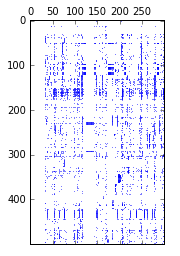

In [74]:
import sklearn
from sklearn import datasets
W8A = sklearn.datasets.load_svmlight_file('./w8a.t')
X_w8a = W8A[0]
Y_w8a = W8A[1]
print(type(X_w8a))
print(X_w8a.shape)
D = X_w8a.shape[0]
plt.spy(X_w8a[:500,:], marker='.', markersize=0.6)

In [77]:
func = lambda w: logistic(w, X_w8a, Y_w8a)
grad = lambda w: logistic_grad(w, X_w8a, Y_w8a)
hess = lambda w: logistic_hess(w, X_w8a, Y_w8a)
gauss_  = lambda A, b: spla.spsolve(A, b) if sps.issparse(A) else sla.solve(A, b)
lgmres_  = lambda A, b: spla.lgmres(A, b)[0]
cg_  = lambda A, b: spla.cg(A, b)[0]

w = np.zeros(X_w8a.shape[1])
%time w_opt, fvals, ngrads = newton(func, grad, hess, w, lgmres_)
%time w_opt, fvals, ngrads = newton(func, grad, hess, w, cg_)
%time w_opt, fvals, ngrads = newton(func, grad, hess, w, gauss_)

print(w_opt)
print(sla.norm(grad(w_opt)))

time for computing hessian and gradient: 7.137141942977905
time for solving linear system: 0.18231606483459473
CPU times: user 7.72 s, sys: 592 ms, total: 8.31 s
Wall time: 8.36 s
time for computing hessian and gradient: 7.565178155899048
time for solving linear system: 0.13944530487060547
CPU times: user 8.03 s, sys: 764 ms, total: 8.79 s
Wall time: 8.8 s
time for computing hessian and gradient: 6.28889274597168
time for solving linear system: 0.36693906784057617
CPU times: user 9.06 s, sys: 5.93 s, total: 15 s
Wall time: 8.88 s
[-1.0866248 -1.326695 -1.7597709 -1.4587039 -2.1131473 -1.0553078
 -0.83176034 -0.70889833 -0.78034229 -1.6803541 -1.6762302 -0.50921699
 -0.37939587 -0.80800273 -0.47928857 -1.993703 -0.35319075 -0.89155304
 -1.6696523 -1.274047 -2.383869 -0.83727305 -1.5883375 -0.78790016
 -0.80714848 -1.0024614 -1.1191269 -1.3233281 -0.82053173 -1.4525305
 -0.86570238 -0.59766025 -1.1089157 -1.2915864 -1.5758088  0.22364084
 -1.1868939 -0.95448908  0.10658713  0.75630396  0

## a9a

<class 'scipy.sparse.csr.csr_matrix'>
(16281, 122)


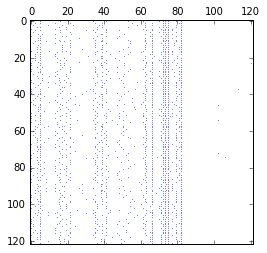

In [73]:
import sklearn
from sklearn import datasets
A9A = sklearn.datasets.load_svmlight_file('./a9a.t')
X_a9a = A9A[0]
Y_a9a = A9A[1]
print(type(X_a9a))
print(X_a9a.shape)
D = X_a9a.shape[0]
plt.spy(X_a9a[:122,:], marker='.', markersize=0.6)

In [68]:
func = lambda w: logistic(w, X_a9a, Y_a9a)
grad = lambda w: logistic_grad(w, X_a9a, Y_a9a)
hess = lambda w: logistic_hess(w, X_a9a, Y_a9a)
gauss_  = lambda A, b: spla.spsolve(A, b) if sps.issparse(A) else sla.solve(A, b)
lgmres_  = lambda A, b: spla.lgmres(A, b)[0]
cg_  = lambda A, b: spla.cg(A, b)[0]

w = np.zeros(X_a9a.shape[1])
%time w_opt, fvals, ngrads = newton(func, grad, hess, w, lgmres_)
%time w_opt, fvals, ngrads = newton(func, grad, hess, w, cg_)
%time w_opt, fvals, ngrads = newton(func, grad, hess, w, gauss_)
print(w_opt)
print(sla.norm(grad(w_opt)))

time for computing hessian and gradient: 5.315335035324097
time for solving linear system: 0.13559341430664062
CPU times: user 6.1 s, sys: 360 ms, total: 6.46 s
Wall time: 6.57 s
time for computing hessian and gradient: 4.863441705703735
time for solving linear system: 0.050415992736816406
CPU times: user 5.69 s, sys: 188 ms, total: 5.88 s
Wall time: 5.89 s
time for computing hessian and gradient: 4.866555690765381
time for solving linear system: 0.1965193748474121
CPU times: user 7.98 s, sys: 4.95 s, total: 12.9 s
Wall time: 7.35 s
[-1.4411055 -0.37321919  0.1433261  0.45912854  0.42774938  0.43117819
 -0.10351919  0.59314176  0.8150107  0.28682404  0.072576681  0.34420421
 -0.004316392 -0.33965398 -0.18295947 -0.12915246 -0.079281867 -0.053072872
 -0.23857332 -0.071814719 -0.0065691384 -0.26223796  0.65820718  0.1359473
 -0.13035403 -0.35260193 -0.44256651  0.39120245  0.033557367 -0.71868721
 -0.13546494  0.37453152 -0.13937265  0.12067593 -1.283384 -0.26223796
 -0.071814719  0.0055

Как и ожидалось основное время тратится на расчет гессиана и градиента. Системы линейных уравнений лучше решать либо методом lgmres, либо cg. Для lgmres правда нужно дополнительно подбирать параметр tol.

**Задача 6.4 (0 балов, весь код написан за Вас, но очень красивые картинки)** 

Давайте визуализируем наш метод, а то хочется глазами посмотреть. Просто запустите код:

In [83]:
from scipy import optimize
from scipy.sparse.linalg import cg

def expand(X):
    X_ = np.zeros((X.shape[0], 6))
    X_[:,0:2] = X
    X_[:,2:4] = X**2
    X_[:,4] = X[:,0] * X[:,1]
    X_[:,5] = 1;
    return X_

def visualize(X, y, w, loss, n_iter, h=0.01):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    plt.clf()
    Z = classify(expand(np.c_[xx.ravel(), yy.ravel()]), w)
    Z = Z.reshape(xx.shape)
    plt.subplot(1,2,1)
    plt.contourf(xx, yy, Z, cmap='rainbow', alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='rainbow')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.subplot(1,2,2)
    plt.plot(loss)
    ymin, ymax = plt.ylim()
    plt.ylim(0, ymax)
    display.clear_output(wait=True)
    display.display(plt.gcf())
    
def viz_opt(func, gradf, hessf, X, y, n_iter=10):
    a = None
    loss1 = np.zeros(n_iter)
    plt.figure(figsize=(12,5))
    ind = np.arange(X.shape[0])
    
    w, d = np.zeros(X.shape[1]), np.zeros(X.shape[1])
    
    for i in range(n_iter):        
        loss1[i] += func(w)
        visualize(X, y, w, loss1, n_iter)
        
        fvalx, gradx, hessx = func(w), grad(w), hess(w)
        d = cg(hessx, -gradx)[0]
        alpha = line_search_armijo(func, w, d, gradx, fvalx)[0]
        w += alpha*d
        
    visualize(X, y, w, loss1, n_iter)
    
    q = plt.clf()
    plt.show()

In [84]:
from sklearn.datasets import make_moons, make_circles, make_classification

X, y = make_classification(n_features=2, n_redundant=0, n_informative=2)
X += np.random.random(X.shape)

datasets = [make_moons(noise=0.1), make_circles(noise=0.1, factor=0.5), (X, y)]

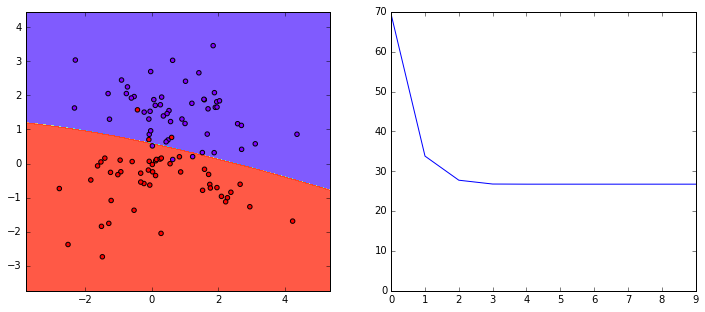

In [85]:
from IPython import display

def classify(X, w):
    return np.sign(1.0 / (1.0 + np.exp(-X.dot(w))) - 0.5)

func = lambda w: logistic(w, X, y)
grad = lambda w: logistic_grad(w, X, y)
hess = lambda w: logistic_hess(w, X, y)

for X, y in datasets:
    X, y = expand(X), -2*(y-0.5)
    a = viz_opt(func, grad, hess, X, y) 